In [ ]:
!unzip What-Makes-a-Good-Commit-Message-master.zip

In [ ]:
!pip install -U sentence-transformers

## Imports

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from itertools import compress

import pandas as pd
import numpy as np
import re
import matplotlib.pylab as plt

from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Data processing

In [3]:
dataset_path = '/content/What-Makes-a-Good-Commit-Message-master/Dataset/sampled messages.csv'
data = pd.read_csv(dataset_path, encoding='UTF-8', encoding_errors='ignore')

In [4]:
!wc -l /content/What-Makes-a-Good-Commit-Message-master/Dataset/sampled\ messages.csv

1653 /content/What-Makes-a-Good-Commit-Message-master/Dataset/sampled messages.csv


In [5]:
data

,id,repo_id,label,url,if_mulit_commit,message,new_message1,authorEmail,commitDate,Unnamed: 9
0,3079,2,0,https://github.com/apache/dubbo/commit/1b2e6dc...,1,remove some magic value (#4752) <enter> <ente...,remove some magic value ( <pr_link> ) <enter>...,developer128,2019-08-06T07:23:45Z,NaN
1,5904,4,0,https://github.com/square/okhttp/commit/2fd0da...,,Update concurrency.md (#6290),Update concurrency.md ( <pr_link> ),developer129,2020-09-30T16:01:02Z,NaN
2,4224,2,0,https://github.com/apache/dubbo/commit/9e9e778...,,Optimize_hessian_desr_performance (#1705),Optimize_hessian_desr_performance ( <pr_link> ),developer130,2018-04-26T10:51:02Z,NaN
3,5382,3,0,https://github.com/square/retrofit/commit/0754...,,Add @PartMap annotation.,Add <iden> annotation.,developer131,2014-05-01T17:16:02Z,NaN
4,6983,4,3,https://github.com/square/okhttp/commit/c310d2...,,workaround broken system dns behaviour,workaround broken system <file_name> behaviour,developer132,2017-11-17T11:02:26Z,NaN
...,...,...,...,...,...,...,...,...,...,...
1644,3452,2,0,https://github.com/apache/dubbo/commit/789775b...,,Change CopyOnWriteArrayList to regular list in...,Change <iden> to regular list in <file_name> ...,developer335,2019-05-15T03:05:48Z,NaN
1645,3786,2,2,https://github.com/apache/dubbo/commit/84d355f...,,code rule (#3651),code rule ( <pr_link> ),developer336,2019-04-12T03:37:03Z,NaN
1646,3497,2,0,https://github.com/apache/dubbo/commit/3bdc316...,,replace Random with ThreadLocalRandom (#2433),replace <iden> with <iden> ( <pr_link> ),developer337,2018-09-05T03:31:52Z,NaN
1647,13889,5,0,https://github.com/spring-projects/spring-boot...,,Update production-ready-features.adoc <enter> ...,Update <file_name> <enter> Replace line break...,developer338,2016-12-08T11:15:43Z,NaN


% of "good" messages in dataset: 0.5876288659793815


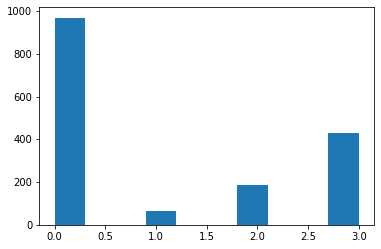

In [6]:
l = data['label'].to_numpy()
plt.hist(l)

print(f'% of "good" messages in dataset: {(l == 0).sum() / len(l)}')

In [7]:
samples_num = len(data)

In [8]:
!wget https://raw.githubusercontent.com/Tbabm/nngen/master/data/cleaned.test.msg

--2022-10-28 20:42:28--  https://raw.githubusercontent.com/Tbabm/nngen/master/data/cleaned.test.msg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100151 (98K) [text/plain]
Saving to: ‘cleaned.test.msg.16’

cleaned.test.msg.16 100%[===================>]  97.80K  --.-KB/s    in 0.002s  

2022-10-28 20:42:28 (60.9 MB/s) - ‘cleaned.test.msg.16’ saved [100151/100151]



In [9]:
test_data = []
with open('cleaned.test.msg', 'r', encoding = 'utf-8') as f:
    test_data = f.readlines()

In [10]:
def process_sample(s):
    s = s.strip()
    s = re.sub(r'(\s)*\.(\s)*', '.', s)
    s = re.sub(r"(\s)*'(\s)*", "'", s)
    s = re.sub(r'#(\s)*', '#', s)
    s = re.sub(r'@(\s)*', '@', s)
    s = re.sub(r'(\s)*\((\s)*', '(', s)
    s = re.sub(r'(\s)*\)', ')', s)
    return s 

In [11]:
test_data = [process_sample(x) for x in test_data]
# print(len(test_data))

test_df = pd.DataFrame()
test_df['message'] = test_data
test_df['label'] = [0 for i in range(len(test_data))]
test_df['id'] = [i for i in range(len(test_data))]
test_dataset_path = 'test_data.csv'
test_df.to_csv(test_dataset_path) 

In [12]:
class CommitsDataset(Dataset):
    def __init__(self, dataset_path, encoder, mask):
        data = pd.read_csv(dataset_path, encoding='UTF-8', encoding_errors='ignore')
        # data['new_label'] = [0 if x == 0 else 1 for x in data['label'].tolist()]
        self.labels = np.array(data['label'])[mask]
        # processed_messages = data['new_message1'].to_numpy()[mask]
        processed_messages = data['message'].to_numpy()[mask]
        self.encoded_messages = encoder.encode(processed_messages)
        self.ids =  np.array(data['id'])[mask]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded_message = self.encoded_messages[idx]
        id = self.ids[idx]
        label = self.labels[idx]
        return encoded_message, id, label

In [13]:
class CommitsBertDataset(Dataset):
    def __init__(self, dataset_path, tokenizer, mask):
        data = pd.read_csv(dataset_path, encoding='UTF-8', encoding_errors='ignore')
        self.labels = np.array(data['label'])[mask]
        processed_messages = list(compress(data['message'].tolist(), mask))
        self.encoded_messages = tokenizer(
            processed_messages,
            padding=True,
            truncation=True,
            max_length=200,
            return_tensors='pt'
        )['input_ids']
        self.ids =  np.array(data['id'])[mask]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded_message = self.encoded_messages[idx]
        id = self.ids[idx]
        label = self.labels[idx]
        return encoded_message, id, label

In [14]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [15]:
class CommitsSTDataset(Dataset):
    def __init__(self, dataset_path, mask):
        data = pd.read_csv(dataset_path, encoding='UTF-8', encoding_errors='ignore')
        self.labels = np.array(data['label'])[mask]
        self.processed_messages = list(compress(data['message'].tolist(), mask))
        self.ids =  np.array(data['id'])[mask]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        processed_messages = self.processed_messages[idx]
        id = self.ids[idx]
        label = self.labels[idx]
        return processed_messages, id, label

In [16]:
mask = np.zeros(samples_num)
mask[:int(0.8 * samples_num)] = 1
np.random.shuffle(mask)

## BiLSTM with frozen Sentence Transformer

Using Sentence Transformer as encoder and passing the output to BiLSTM without gradient propagation. It is a fast approach. Using 2 classes instead of 4 does not boost performance. 

In [27]:
class BiLSTM(nn.Module):
    def __init__(self, embed_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = 128
        dropout = 0.5
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size * 2, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(128, 4)


    def forward(self, x):
        #print(x.shape)
        h_embedding = torch.squeeze(torch.unsqueeze(x, 0))
        #print(h_embedding.shape)
        h_lstm, _ = self.lstm(x)
        #print(h_lstm.shape)
        # avg_pool = torch.mean(h_lstm, 1)
        # max_pool, _ = torch.max(h_lstm, 1)
        # print(avg_pool.shape, max_pool.shape)
        conc = h_lstm# torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out


In [28]:
def train(model, train_loader, valid_loader, config):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    for e in range(config['epochs']):
        model.train()
        train_loss = 0.
        train_acc = 0.
        for encs, ids, labels in train_loader:
            optimizer.zero_grad()
            output = model(encs.to(device))
            loss = criterion(output.squeeze(), labels.long().to(device))
            train_loss += loss.item()
            train_acc += (
                torch.argmax(output.squeeze(), dim=1) == labels.to(device)
            ).sum()
            loss.backward()
            optimizer.step()
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        if valid_loader is None:
            print(f'epoch: {e} | train loss: {train_loss} | train accuracy: {train_acc}')
            continue
        model.eval()
        valid_loss = 0.
        valid_acc = 0.
        with torch.no_grad():
            for encs, ids, labels in valid_loader:
                output = model(encs.to(device))
                loss = criterion(output.squeeze(), labels.long().to(device))
                valid_loss += loss.item()
                valid_acc += (
                    torch.argmax(output.squeeze(), dim=1) == labels.to(device)
                ).sum()
            valid_loss /= len(valid_loader.dataset)
            valid_acc /= len(valid_loader.dataset)
        print(f'epoch: {e} | train loss: {train_loss} | train accuracy: {train_acc} | valid loss: {valid_loss} | valid accuracy: {valid_acc}')

In [29]:
def test(model, test_loader):
    outputs = []
    model.eval()
    with torch.no_grad():
        for encs, ids, labels in test_loader:
            output = model(encs.to(device))
            outputs += torch.argmax(output.squeeze(), dim=1).tolist()
    return outputs

In [31]:
encoder = SentenceTransformer('all-mpnet-base-v2')

In [32]:
train_dataset = CommitsDataset(dataset_path, encoder, mask.astype(bool))
valid_dataset = CommitsDataset(dataset_path, encoder, (1 - mask).astype(bool))

In [33]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [34]:
model = BiLSTM(768).to(device)

In [35]:
config = {
    'lr': 7e-4,
    'epochs': 20,
    'batch_size': 64
}

In [36]:
train(model, train_loader, valid_loader, config)

epoch: 0 | train loss: 0.019918564461324142 | train accuracy: 0.469294935464859 | valid loss: 0.019929806210777976 | valid accuracy: 0.5636363625526428
epoch: 1 | train loss: 0.01682346200653782 | train accuracy: 0.5936315655708313 | valid loss: 0.018875442671053337 | valid accuracy: 0.5636363625526428
epoch: 2 | train loss: 0.01627365900224768 | train accuracy: 0.5936315655708313 | valid loss: 0.018608589967091877 | valid accuracy: 0.5636363625526428
epoch: 3 | train loss: 0.016246950066026365 | train accuracy: 0.5936315655708313 | valid loss: 0.018341450980215362 | valid accuracy: 0.5636363625526428
epoch: 4 | train loss: 0.01578324631003379 | train accuracy: 0.5936315655708313 | valid loss: 0.01786701661167723 | valid accuracy: 0.5636363625526428
epoch: 5 | train loss: 0.014976000541805588 | train accuracy: 0.5943896770477295 | valid loss: 0.017376103726300326 | valid accuracy: 0.5636363625526428
epoch: 6 | train loss: 0.01432502522804775 | train accuracy: 0.6072782278060913 | valid

In [37]:
full_dataset = CommitsDataset(dataset_path, encoder, (np.ones(samples_num)).astype(bool))
full_train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
test_dataset = CommitsDataset(test_dataset_path, encoder, (np.ones(len(test_data))).astype(bool))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [38]:
model = BiLSTM(768).to(device)
train(model, full_train_loader, None, config)

epoch: 0 | train loss: 0.018956096986339193 | train accuracy: 0.5530624389648438
epoch: 1 | train loss: 0.016441591477090477 | train accuracy: 0.5870224237442017
epoch: 2 | train loss: 0.015982205901021593 | train accuracy: 0.5882353186607361
epoch: 3 | train loss: 0.01532189953753701 | train accuracy: 0.5876288414001465
epoch: 4 | train loss: 0.014473267654132092 | train accuracy: 0.6294723749160767
epoch: 5 | train loss: 0.013480249645494562 | train accuracy: 0.6513038277626038
epoch: 6 | train loss: 0.012906478346297783 | train accuracy: 0.6737416386604309
epoch: 7 | train loss: 0.012234541341852173 | train accuracy: 0.6973923444747925
epoch: 8 | train loss: 0.011576235294342041 | train accuracy: 0.7155851721763611
epoch: 9 | train loss: 0.011268172880748752 | train accuracy: 0.7198302149772644
epoch: 10 | train loss: 0.010598863595322887 | train accuracy: 0.7368102073669434
epoch: 11 | train loss: 0.010385171491641431 | train accuracy: 0.7416616082191467
epoch: 12 | train loss: 0.0

In [39]:
pred_labels = test(model, test_loader)

res = pd.DataFrame()
res['message'] = test_df['message']
res['predicted_label'] = pred_labels
res.to_csv('predictions1.csv')

In [40]:
res.head(5)

,message,predicted_label
0,Fix snapshot version,0
1,update chagelog,3
2,edit coverage colors icon,0
3,LRQA - 14419 Add new property to turn on runni...,3
4,Added joscar JAR.,0


##BiLSTM with BERT finetuning

Using BERT as encoder and passing the output to BiLSTM with gradient propagation. This is original approach from paper. It works better, then the previous one, but is much slower. 


In [17]:
class BERT_BiLSTM(nn.Module):
    def __init__(self):
        super(BERT_BiLSTM, self).__init__()
        self.output_size = 4
        self.n_layers = 2
        self.hidden_dim = 384
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = True
        self.lstm = nn.LSTM(768, self.hidden_dim, 2, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(self.hidden_dim * self.n_layers, self.output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = self.bert(x)[0]
        lstm_out, (hidden_last, cn_last) = self.lstm(x, hidden)
        hidden_last_L = hidden_last[-2]
        hidden_last_R = hidden_last[-1]
        hidden_last_out = torch.cat([hidden_last_L, hidden_last_R], dim=-1)
        out = self.dropout(hidden_last_out)
        out = self.fc(out)
        return out

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        number = 2
        hidden = (
            weight.new(self.n_layers * number, batch_size, self.hidden_dim).zero_().float().to(device),
            weight.new(self.n_layers * number, batch_size, self.hidden_dim).zero_().float().to(device)
        )
        return hidden

In [18]:
def train_bert(model, train_loader, valid_loader, config):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    for e in range(config['epochs']):
        model.train()
        train_loss = 0.
        train_acc = 0.
        for encs, ids, labels in train_loader:
            labels = labels.long().to(device)
            encs = encs.to(device)
            h = model.init_hidden(len(labels))
            h = tuple([each.data for each in h])
            optimizer.zero_grad()
            output = model(encs, h)
            loss = criterion(output.squeeze(), labels)
            train_loss += loss.item()
            train_acc += (
                torch.argmax(output.squeeze(), dim=1) == labels
            ).sum()
            loss.backward()
            optimizer.step()
            del h
            del encs
            del labels
            del output

        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)

        if valid_loader is None:
            print(f'epoch: {e} | train loss: {train_loss} | train accuracy: {train_acc}')
            continue
        model.eval()
        valid_loss = 0.
        valid_acc = 0.
        with torch.no_grad():
            for encs, ids, labels in valid_loader:
                labels = labels.long().to(device)
                encs = encs.to(device)
                h = model.init_hidden(len(labels))
                h = tuple([each.data for each in h])
                output = model(encs, h)
                loss = criterion(output.squeeze(), labels)
                valid_loss += loss.item()
                valid_acc += (
                    torch.argmax(output.squeeze(), dim=1) == labels
                ).sum()
                del h
                del encs
                del labels
                del output
            valid_loss /= len(valid_loader.dataset)
            valid_acc /= len(valid_loader.dataset)

        print(f'epoch: {e} | train loss: {train_loss} | train accuracy: {train_acc} | valid loss: {valid_loss} | valid accuracy: {valid_acc}')


def test_bert(model, test_loader):
    outputs = []
    model.eval()
    
    with torch.no_grad():
        for encs, ids, labels in test_loader:
            h = model.init_hidden(len(labels))
            h = tuple([each.data for each in h])
            output = model(encs.to(device), h)
            outputs += torch.argmax(output.squeeze(), dim=1).tolist()
    return outputs        

In [19]:
config = {
    'lr': 3e-5,
    'epochs': 20,
    'batch_size': 64
}

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [21]:
train_dataset_bert = CommitsBertDataset(dataset_path, tokenizer, mask.astype(bool))
valid_dataset_bert = CommitsBertDataset(dataset_path, tokenizer, (1 - mask).astype(bool))
train_loader_bert = DataLoader(train_dataset_bert, batch_size=64, shuffle=True)
valid_loader_bert = DataLoader(valid_dataset_bert, batch_size=64, shuffle=False)

In [22]:
bert_model = BERT_BiLSTM().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
train_bert(bert_model, train_loader_bert, valid_loader_bert, config)

epoch: 0 | train loss: 0.01798881397182242 | train accuracy: 0.5686125755310059 | valid loss: 0.017907411040681782 | valid accuracy: 0.5909090638160706
epoch: 1 | train loss: 0.01510823843965393 | train accuracy: 0.5989385843276978 | valid loss: 0.015949981140367914 | valid accuracy: 0.6363636255264282
epoch: 2 | train loss: 0.01419206258471578 | train accuracy: 0.6641395092010498 | valid loss: 0.015580966436501704 | valid accuracy: 0.6454545259475708
epoch: 3 | train loss: 0.013048418594906961 | train accuracy: 0.6974981427192688 | valid loss: 0.015521897691668887 | valid accuracy: 0.6575757265090942
epoch: 4 | train loss: 0.01144402193426634 | train accuracy: 0.7255496978759766 | valid loss: 0.014255308201818756 | valid accuracy: 0.6969696879386902
epoch: 5 | train loss: 0.009868200639597478 | train accuracy: 0.7589082717895508 | valid loss: 0.01340754104383064 | valid accuracy: 0.7060605883598328
epoch: 6 | train loss: 0.007739302558913386 | train accuracy: 0.8369977474212646 | vali

In [20]:
full_dataset = CommitsBertDataset(dataset_path, tokenizer, (np.ones(samples_num)).astype(bool))
full_train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
test_dataset = CommitsBertDataset(test_dataset_path, tokenizer, (np.ones(len(test_data))).astype(bool))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [21]:
bert_model = BERT_BiLSTM().to(device)
train_bert(bert_model, full_train_loader, None, config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 0 | train loss: 0.016900340595557662 | train accuracy: 0.5694360136985779
epoch: 1 | train loss: 0.014165746037926799 | train accuracy: 0.6488780975341797
epoch: 2 | train loss: 0.01345195807855443 | train accuracy: 0.6604002118110657
epoch: 3 | train loss: 0.012375553099584262 | train accuracy: 0.6846573352813721
epoch: 4 | train loss: 0.010449343337804494 | train accuracy: 0.743480920791626
epoch: 5 | train loss: 0.009497820788835163 | train accuracy: 0.7731958627700806
epoch: 6 | train loss: 0.006980460536993222 | train accuracy: 0.8483929634094238
epoch: 7 | train loss: 0.0054973232124414205 | train accuracy: 0.8884172439575195
epoch: 8 | train loss: 0.0037517854893041277 | train accuracy: 0.9296543002128601
epoch: 9 | train loss: 0.0025020235908833903 | train accuracy: 0.9551243185997009
epoch: 10 | train loss: 0.0018700689728004126 | train accuracy: 0.969072163105011
epoch: 11 | train loss: 0.0012547488467233552 | train accuracy: 0.9763492941856384
epoch: 12 | train loss: 

In [24]:
pred_labels = test_bert(bert_model, test_loader)

res = pd.DataFrame()
res['message'] = test_df['message']
res['predicted_label'] = pred_labels
res.to_csv('predictions2.csv') 

In [25]:
res.head(5)

,message,predicted_label
0,Fix snapshot version,0
1,update chagelog,0
2,edit coverage colors icon,3
3,LRQA - 14419 Add new property to turn on runni...,0
4,Added joscar JAR.,3


##Finetuning Sentence Transformer

Finetuning Sentence Transformer model. Works faster than BERT + LSTM but performance is slightly worse.

In [27]:
config = {
    'lr': 1e-4,
    'epochs': 15,
    'batch_size': 16
}

In [44]:
class ST_Finetune(nn.Module):
    def __init__(self):
        super(ST_Finetune, self).__init__()
        self.output_size = 4
        self.n_layers = 2
        self.hidden_dim = 384
        self.st = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

        for param in self.st.parameters():
            param.requires_grad = True
        self.fc1 = nn.Linear(384, self.hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_size)

    def forward(self, x):
        for e in x:
          batch_size = len(x[e])  
          break
        model_output = self.st(**x)
        sentence_embeddings = mean_pooling(model_output, x['attention_mask'])
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        out = self.fc1(sentence_embeddings)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [50]:
def train_st(model, train_loader, valid_loader, config):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

    for e in range(config['epochs']):
        model.train()
        train_loss = 0.
        train_acc = 0.
        for msgs, ids, labels in train_loader:
            encs = tokenizer(
                list(msgs), 
                padding=True, 
                truncation=True, 
                return_tensors='pt'
            )
            if len(labels) == 1:
              continue
            optimizer.zero_grad()
            output = model(encs.to(device))
            loss = criterion(output.squeeze(), labels.long().to(device))
            train_loss += loss.item()
            train_acc += (
                torch.argmax(output.squeeze(), dim=1) == labels.to(device)
            ).sum()
            loss.backward()
            optimizer.step()
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)

        if valid_loader is None:
            print(f'epoch: {e} | train loss: {train_loss} | train accuracy: {train_acc}')
            continue
        model.eval()
        valid_loss = 0.
        valid_acc = 0.
        with torch.no_grad():
            for msgs, ids, labels in valid_loader:
                encs = tokenizer(
                    list(msgs), 
                    padding=True, 
                    truncation=True, 
                    return_tensors='pt'
                )
                output = model(encs.to(device))
                loss = criterion(output.squeeze(), labels.long().to(device))
                valid_loss += loss.item()
                valid_acc += (
                    torch.argmax(output.squeeze(), dim=1) == labels.to(device)
                ).sum()
            valid_loss /= len(valid_loader.dataset)
            valid_acc /= len(valid_loader.dataset)
        print(f'epoch: {e} | train loss: {train_loss} | train accuracy: {train_acc} | valid loss: {valid_loss} | valid accuracy: {valid_acc}')


def test_st(model, test_loader):
    outputs = []
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

    with torch.no_grad():
        for msgs, ids, labels in test_loader:
            encs = tokenizer(
                  list(msgs), 
                  padding=True, 
                  truncation=True, 
                  return_tensors='pt'
              )
            output = model(encs.to(device))
            outputs += torch.argmax(output.squeeze(), dim=1).tolist()
    return outputs        

In [46]:
train_dataset_st = CommitsSTDataset(dataset_path, mask.astype(bool))
valid_dataset_st = CommitsSTDataset(dataset_path, (1 - mask).astype(bool))
train_loader_st = DataLoader(train_dataset_st, batch_size=config["batch_size"], shuffle=True)
valid_loader_st = DataLoader(valid_dataset_st, batch_size=config["batch_size"], shuffle=False)

In [47]:
st_model = ST_Finetune().to(device)
train_st(st_model, train_loader_st, valid_loader_st, config)

epoch: 0 | train loss: 0.07563065786629215 | train accuracy: 0.6148597598075867 | valid loss: 0.0681510638106953 | valid accuracy: 0.663636326789856
epoch: 1 | train loss: 0.05886151747237199 | train accuracy: 0.7240333557128906 | valid loss: 0.05709372695648309 | valid accuracy: 0.6909090876579285
epoch: 2 | train loss: 0.047363306194476054 | train accuracy: 0.7717968225479126 | valid loss: 0.0539953528028546 | valid accuracy: 0.6727272272109985
epoch: 3 | train loss: 0.03661681778327907 | train accuracy: 0.840030312538147 | valid loss: 0.049816231565041974 | valid accuracy: 0.7121211886405945
epoch: 4 | train loss: 0.02741168642739982 | train accuracy: 0.8870356678962708 | valid loss: 0.048275436190041626 | valid accuracy: 0.7242423892021179
epoch: 5 | train loss: 0.021445960165132078 | train accuracy: 0.920394241809845 | valid loss: 0.049698204795519514 | valid accuracy: 0.7393938899040222
epoch: 6 | train loss: 0.017976380401687066 | train accuracy: 0.9393479824066162 | valid loss:

In [48]:
full_dataset = CommitsSTDataset(dataset_path, (np.ones(samples_num)).astype(bool))
full_train_loader = DataLoader(full_dataset, batch_size=config["batch_size"], shuffle=True)
test_dataset = CommitsSTDataset(test_dataset_path, (np.ones(len(test_data))).astype(bool))
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

In [49]:
st_model = ST_Finetune().to(device)
train_st(st_model, full_train_loader, None, config)

epoch: 0 | train loss: 0.07277277717451532 | train accuracy: 0.6040024161338806
epoch: 1 | train loss: 0.05319581923158043 | train accuracy: 0.7453001737594604
epoch: 2 | train loss: 0.03815058108674461 | train accuracy: 0.8332322835922241
epoch: 3 | train loss: 0.027837291061697474 | train accuracy: 0.8914493322372437
epoch: 4 | train loss: 0.021739370673623786 | train accuracy: 0.9169193506240845
epoch: 5 | train loss: 0.01689642360529949 | train accuracy: 0.9375379085540771
epoch: 6 | train loss: 0.013519349228421292 | train accuracy: 0.9502728581428528
epoch: 7 | train loss: 0.011012273145361767 | train accuracy: 0.9587628841400146
epoch: 8 | train loss: 0.008644028073724578 | train accuracy: 0.9666464328765869
epoch: 9 | train loss: 0.005551447489808877 | train accuracy: 0.9818071722984314
epoch: 10 | train loss: 0.00633383674514319 | train accuracy: 0.9751364588737488
epoch: 11 | train loss: 0.0066767112584078655 | train accuracy: 0.9702849984169006
epoch: 12 | train loss: 0.0060

In [52]:
pred_labels = test_st(st_model, test_loader)

res = pd.DataFrame()
res['message'] = test_df['message']
res['predicted_label'] = pred_labels
res.to_csv('predictions3.csv') 

In [53]:
res.head(5)

,message,predicted_label
0,Fix snapshot version,0
1,update chagelog,1
2,edit coverage colors icon,0
3,LRQA - 14419 Add new property to turn on runni...,0
4,Added joscar JAR.,1


## Compare results

In [5]:
p1 = pd.read_csv("predictions1.csv")
p2 = pd.read_csv("predictions2.csv")
p3 = pd.read_csv("predictions3.csv")

p1["Freeze ST + BiLSTM"] = p1["predicted_label"]
p1["BERT + BiLSTM"] = p2["predicted_label"]
p1["ST finetune"] = p3["predicted_label"]
del p1["predicted_label"]
p1.to_csv('predictions_all.csv')

In [25]:
p1.sample(30)

,Unnamed: 0,message,Freeze ST + BiLSTM,BERT + BiLSTM,ST finetune
2235,2235,Upgrade ActionBarSherlock to 4.2.0,0,0,0
2174,2174,"Make an internal class package private """,3,3,3
1060,1060,added chromecast to changelog,3,3,0
981,981,Fixing broken dropdown asset in Honeycomb as well,2,0,0
916,916,Remove annoucement on BottomSheetDialog Backgr...,3,0,3
1611,1611,Make blueprints - test a test scope dependency,3,3,3
1546,1546,give access to the defining classloader,3,3,3
1600,1600,Moved two NOPASS tests to pass.,3,3,3
2049,2049,removed email address...peeps can contact me t...,3,0,0
1731,1731,Add first travis config file,3,3,0
